In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /Users/soham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

df = pd.read_csv('/Users/soham/Desktop/JUNE/SENTIMENT ANALYSIS/amazon_alexa.tsv', delimiter = '\t', quoting = 3)



In [4]:
df.head(2)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1


In [5]:
df.shape

(3150, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [7]:
df.isnull().sum()


rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [8]:
df[df['verified_reviews'].isnull() == True]


,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
df.dropna(inplace=True)


In [10]:
df.isnull().sum()


rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [11]:
df.shape

(3149, 5)

In [64]:
df["length"] = df["verified_reviews"].apply(len)

In [13]:
df.head(2)


,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9


In [14]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [15]:
df["rating"].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

In [16]:
df.shape[0] 

3149

In [26]:
df_positive_ratings = round((df[df["rating"].isin([5, 4, 3])].shape[0] / df.shape[0]) * 100, 2)
print(f"Percentage of positive ratings: {df_positive_ratings}%")


Percentage of positive ratings: 91.87%


In [27]:
df_negative_ratings = round((df[df["rating"].isin([1 ,2])].shape[0] / df.shape[0]) * 100, 2)
print(f"Percentage of negative ratings: {df_negative_ratings}%")

Percentage of negative ratings: 8.13%


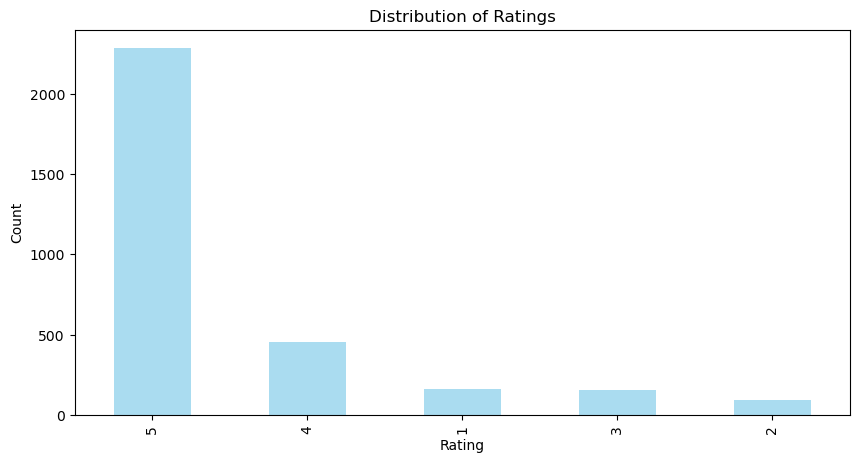

In [32]:
df["rating"].value_counts().plot.bar(figsize=(10, 5), color='skyblue', alpha=0.7)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")    
plt.ylabel("Count")
plt.show()

In [38]:
round((df['rating'].value_counts().sum() / df.shape[0]) * 100, 2)
rating_percentages = (df['rating'].value_counts(normalize=True) * 100).round(2)
print(rating_percentages)

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: proportion, dtype: float64


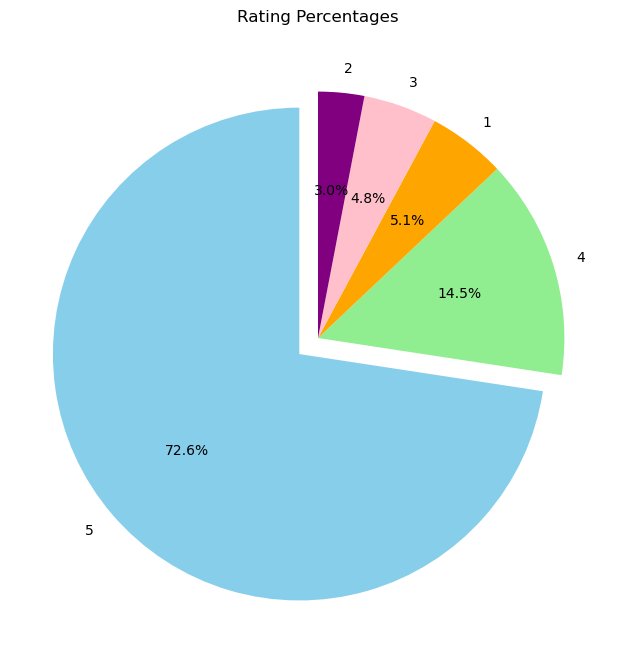

In [40]:

plt.figure(figsize=(8, 8))
rating_percentages.plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['skyblue', 'lightgreen', 'orange', 'pink', 'purple'], 
    labels=rating_percentages.index, 
    explode=[0.1 if rating == 5 else 0 for rating in rating_percentages.index]
)
plt.title("Rating Percentages")
plt.ylabel("") 
plt.show()

In [41]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [42]:

feedback_1_reviews = df[df['feedback'] == 1]['verified_reviews']
print("Feedback 1 Reviews:")
print(feedback_1_reviews.head(10))  


feedback_0_reviews = df[df['feedback'] == 0]['verified_reviews']
print("\nFeedback 0 Reviews:")
print(feedback_0_reviews.head(10))  

Feedback 1 Reviews:
0                                        Love my Echo!
1                                            Loved it!
2    "Sometimes while playing a game, you can answe...
3    "I have had a lot of fun with this thing. My 4...
4                                                Music
5    "I received the echo as a gift. I needed anoth...
6    "Without having a cellphone, I cannot use many...
7    I think this is the 5th one I've purchased. I'...
8                                          looks great
9    "Love it! I’ve listened to songs I haven’t hea...
Name: verified_reviews, dtype: object

Feedback 0 Reviews:
46     "It's like Siri, in fact, Siri answers more ac...
111    Sound is terrible if u want good music too get...
141                                   Not much features.
162    "Stopped working after 2 weeks ,didn't follow ...
176                                 Sad joke. Worthless.
187    "Really disappointed Alexa has to be plug-in t...
205    It's got great sound a

Text(0, 0.5, 'Count')

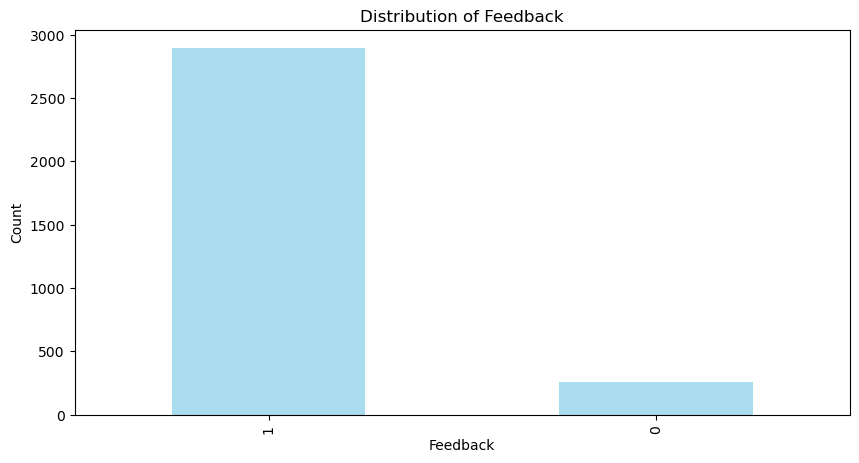

In [43]:
df['feedback'].value_counts().plot.bar(figsize=(10, 5), color='skyblue', alpha=0.7)
plt.title("Distribution of Feedback")
plt.xlabel("Feedback")
plt.ylabel("Count")

In [45]:
round((df['feedback'].value_counts() / df.shape[0]) * 100, 2)

feedback
1    91.87
0     8.13
Name: count, dtype: float64

In [47]:
df[df["feedback"]==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [48]:
df[df["feedback"]==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [52]:
feedback_3_reviews = df[df['rating'] == 3]['verified_reviews']

print(feedback_3_reviews.head(10))  

6      "Without having a cellphone, I cannot use many...
24     "I got a second unit for the bedroom, I was ex...
33     The speakers sound pretty good for being so sm...
49     No different than Apple. To play a specific li...
54                                    like google better
145    it's annoying that everything they show Alexa ...
150    "Doesn't know half the things asked. Can't rec...
166    I like the product except that the speakers ar...
183                                                     
188    I don't think the &#34;2nd gen&#34; sounds as ...
Name: verified_reviews, dtype: object


In [53]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Variations')

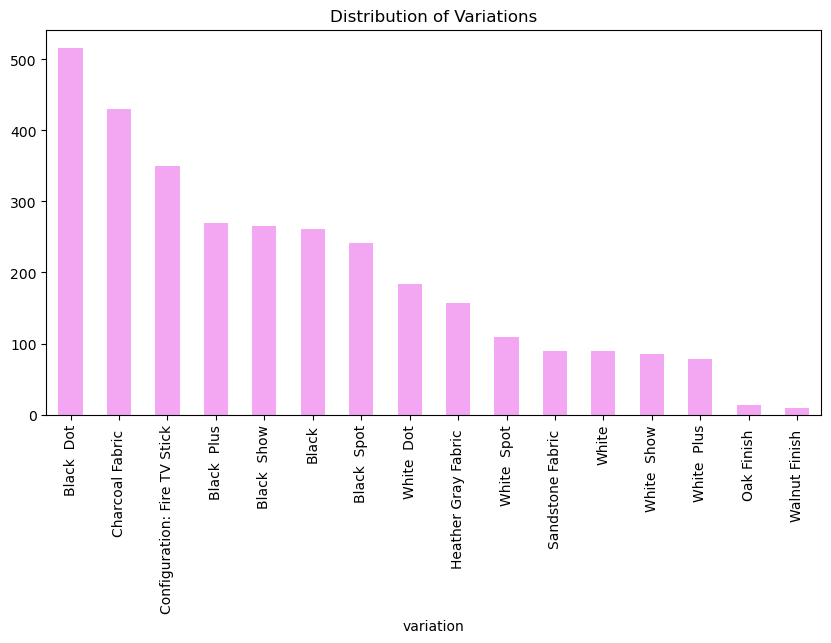

In [57]:
df['variation'].value_counts().plot.bar(figsize=(10, 5), color='VIOLET', alpha=0.7)
plt.title("Distribution of Variations")


variation
Walnut Finish                   4.888889
Oak Finish                      4.857143
Charcoal Fabric                 4.730233
Heather Gray Fabric             4.694268
Configuration: Fire TV Stick    4.591429
Black  Show                     4.490566
Black  Dot                      4.453488
White  Dot                      4.423913
Black  Plus                     4.370370
White  Plus                     4.358974
Sandstone Fabric                4.355556
White  Spot                     4.311927
Black  Spot                     4.311203
White  Show                     4.282353
Black                           4.233716
White                           4.166667
Name: rating, dtype: float64


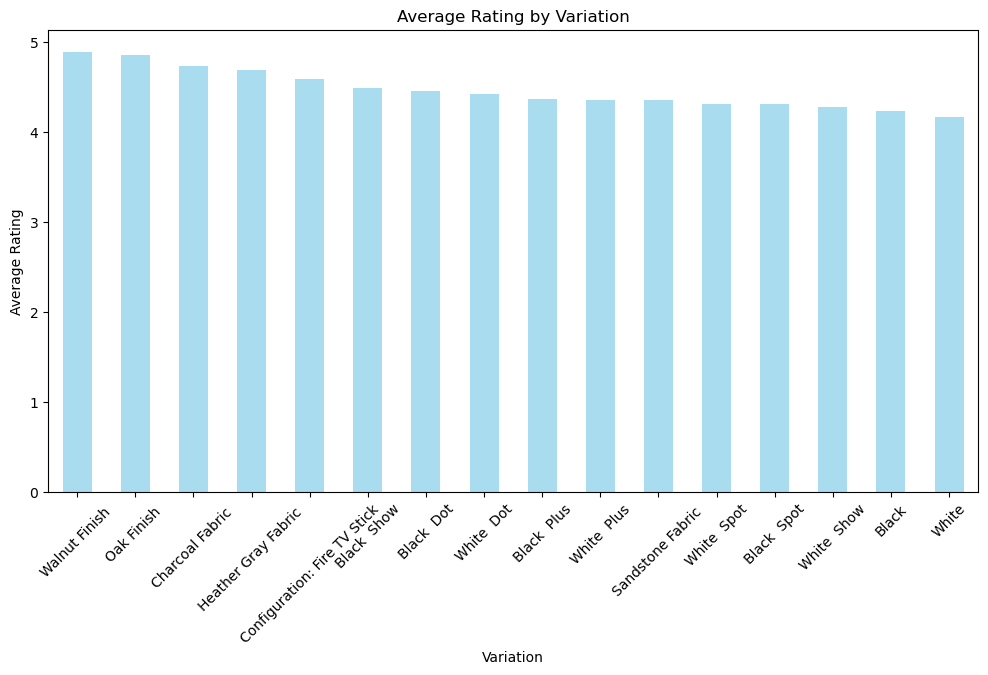

In [59]:
variation_rating_analysis = df.groupby('variation')['rating'].mean().sort_values(ascending=False)
print(variation_rating_analysis)
plt.figure(figsize=(12, 6))
variation_rating_analysis.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title("Average Rating by Variation")
plt.xlabel("Variation")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

In [68]:
round(df['length'].describe(),2)

count    3149.00
mean      132.71
std       182.54
min         1.00
25%        30.00
50%        74.00
75%       166.00
max      2853.00
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

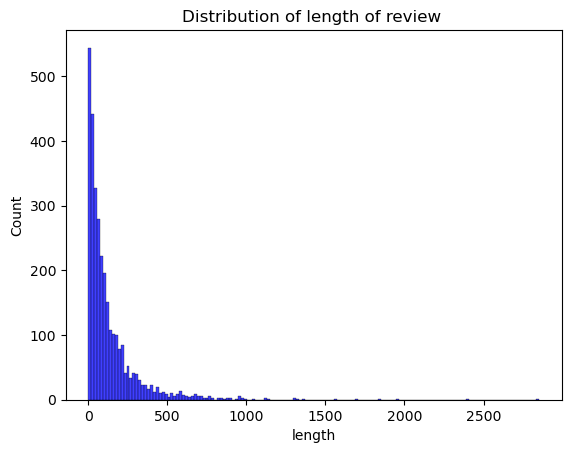

In [74]:
sns.histplot(df['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

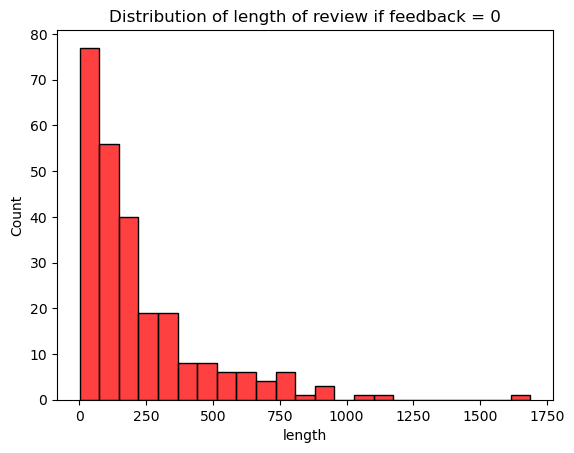

In [75]:
sns.histplot(df[df['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

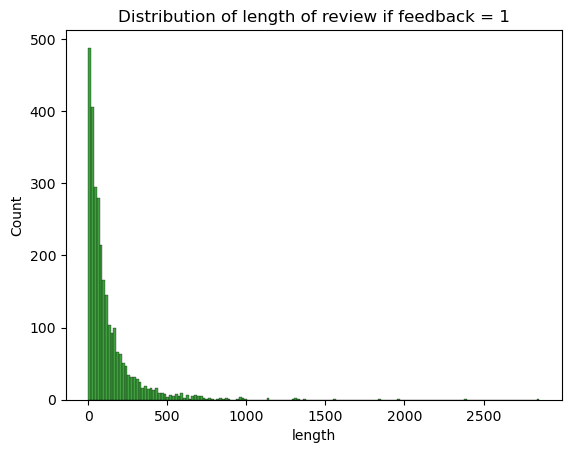

In [76]:
sns.histplot(df[df['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

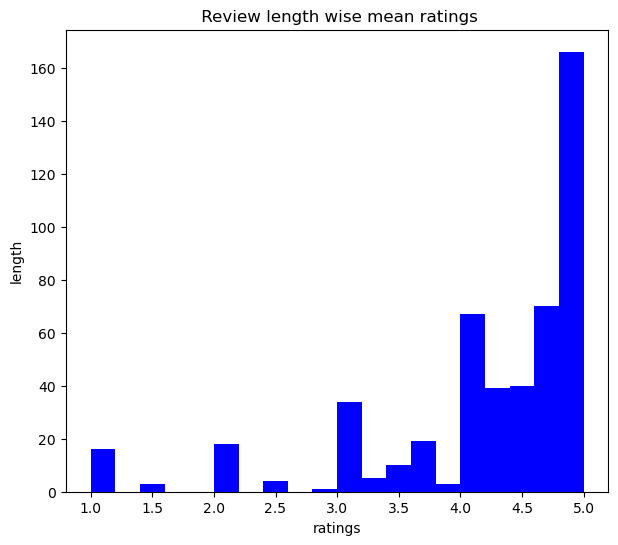

In [77]:
df.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [79]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

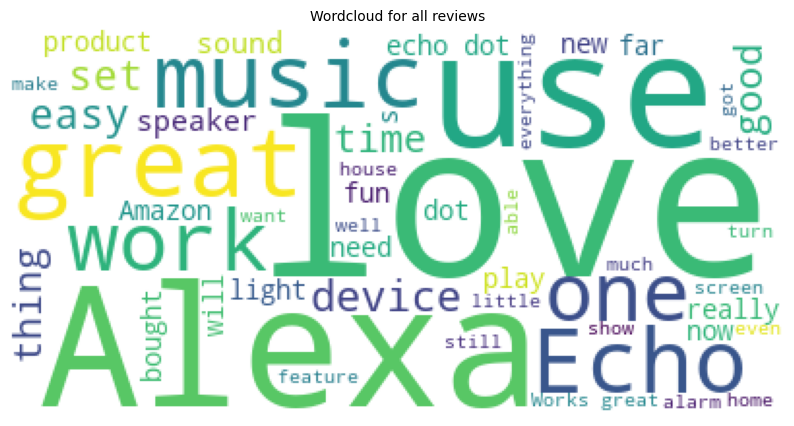

In [80]:
reviews = " ".join([review for review in df['verified_reviews']])
                        
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [84]:
g_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
neg_reviews = g_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

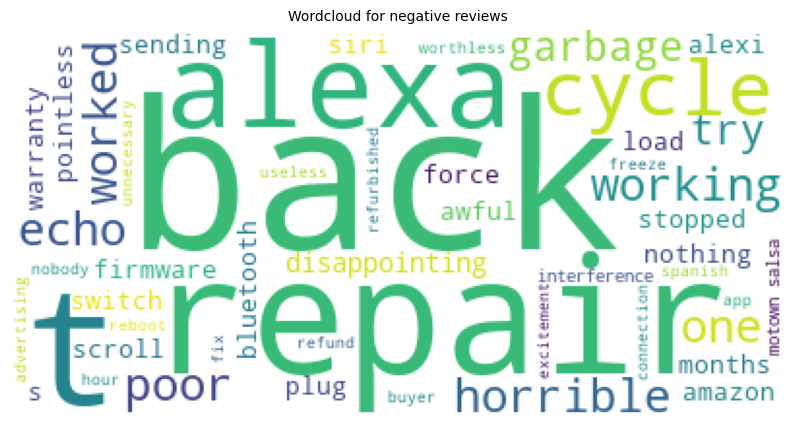

In [85]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

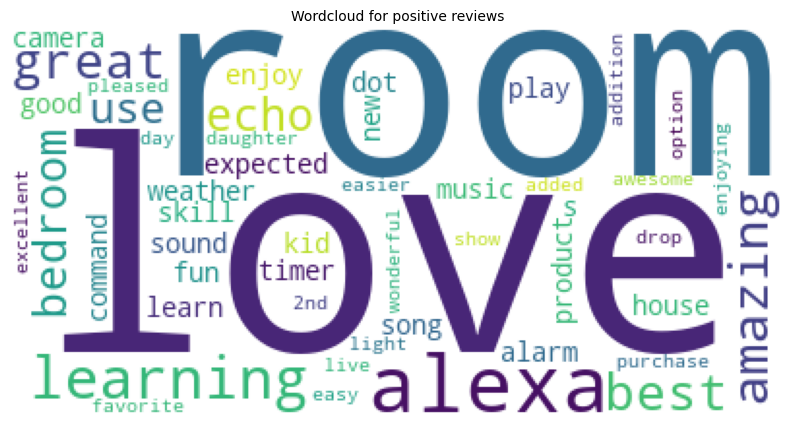

In [86]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [88]:
corpus =[]
stemmer = PorterStemmer()     
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)  

In [89]:
cv = CountVectorizer(max_features=2500)

X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [90]:
pickle.dump(cv, open('count_vectorizer.pkl', 'wb'))

to convert the text data into the numeric we use the count_vectorizer

In [93]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3149, 2500)
Shape of y: (3149,)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)   
print("Shape of y_test:", y_test.shape)


Shape of X_train: (2204, 2500)
Shape of X_test: (945, 2500)
Shape of y_train: (2204,)
Shape of y_test: (945,)


In [95]:
print("train max value:", X_train.max())
print("train min value:", X_train.min())
print("test max value:", X_test.max())
print("test min value:", X_test.min())  

train max value: 12
train min value: 0
test max value: 10
test min value: 0


In [96]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
import os

# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the scaler object
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [99]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
print("Training accuracy :", model_rf.score(X_train, y_train))
print("Testing accuracy :", model_rf.score(X_test, y_test))


Training accuracy : 0.9945553539019963
Testing accuracy : 0.9417989417989417


In [105]:
y_pred = model_rf.predict(X_test)

In [106]:
cm = confusion_matrix(y_test, y_pred)

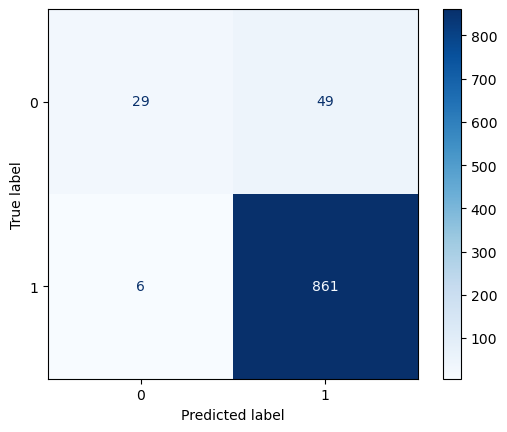

In [107]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [109]:
accuracies = cross_val_score(estimator= model_rf, X= X_train,y= y_train, cv=10)
print("Cross-validation accuracies:", accuracies.mean())
print("Standard Variance:", accuracies.std())

Cross-validation accuracies: 0.9319457013574659
Standard Variance: 0.008338152749457463


In [110]:
params = {
    'bootstrap': [True],
    'max_depth': [80,100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [112]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score= True)
grid_search.fit(X_train, y_train.ravel())       

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [115]:
print("Best parameters found: {}".format(grid_search.best_params_))

Best parameters found: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [118]:
y_preds = grid_search.predict(X_test)

print("Cross validation mean accuracy on train set:{}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set:{}".format(grid_search.cv_results_['mean_test_score'].mean()*100))    
print("Accuracy score for test set:",accuracy_score(y_test, y_preds))





Cross validation mean accuracy on train set:96.67649727767696
Cross validation mean accuracy on test set:92.1676497277677
Accuracy score for test set: 0.9322751322751323


In [120]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [121]:
print("Training accuracy :", model_xgb.score(X_train, y_train)) 
print("Testing accuracy :", model_xgb.score(X_test, y_test))

Training accuracy : 0.971415607985481
Testing accuracy : 0.9417989417989417


In [124]:
y_preds = model_xgb.predict(X_test)


In [125]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 30  48]
 [  7 860]]


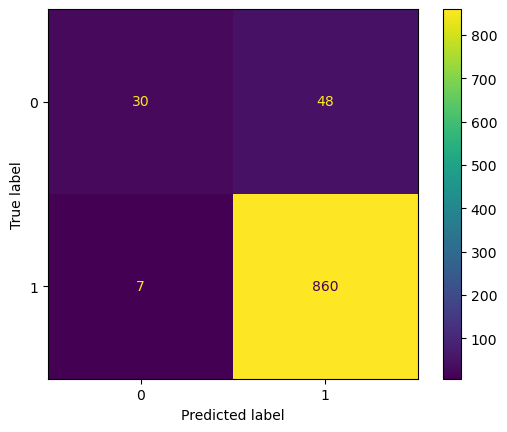

In [127]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_) 
cm_display.plot()                                            

In [128]:
pickle.dump(model_xgb, open('Models/xgb_model.pkl', 'wb'))

In [129]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [131]:
print("Training accuracy :", model_dt.score(X_train, y_train))  
print("Testing accuracy :", model_dt.score(X_test, y_test))


Training accuracy : 0.9945553539019963
Testing accuracy : 0.9185185185185185


In [135]:
y_preds = model_dt.predict(X_test)


In [136]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 42  36]
 [ 41 826]]


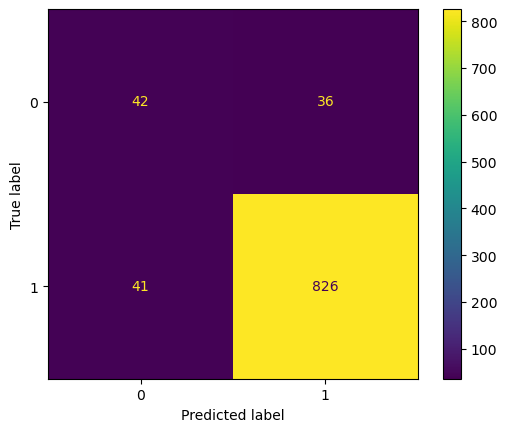

In [134]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()   


In [140]:
# Example code if you trained it
from sklearn.feature_extraction.text import CountVectorizer
import pickle

cv = CountVectorizer()
X = cv.fit_transform(df)  # replace text_data with your dataset

# Save it
with open("Models/countVectorizer.pkl", "wb") as f:
    pickle.dump(cv, f)


In [149]:
import pandas as pd
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Setup
STOPWORDS = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Load and clean data
df_new = pd.read_csv("amazon_alexa.tsv", delimiter="\t", quoting=3)

# Drop row with NaN in 'verified_reviews'
df_new = df_new.dropna(subset=["verified_reviews"])

# Create label
df_new["Label"] = df_new["feedback"]

# Text preprocessing
corpus_new = []
for sentence in df_new["verified_reviews"]:
    review = re.sub("[^a-zA-Z]", " ", sentence)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = " ".join(review)
    corpus_new.append(review)

# Vectorization
cv = CountVectorizer(max_features=2500)
X_new = cv.fit_transform(corpus_new).toarray()

# Scaling
scaler = MinMaxScaler()
X_scaled_new = scaler.fit_transform(X_new)

# Target
y_new = df_new["Label"]

# Train-test split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_scaled_new, y_new, test_size=0.2)

# Model
model_xgb_new = XGBClassifier()
model_xgb_new.fit(X_train_new, y_train_new)

# Save components
pickle.dump(cv, open("Models/countVectorizer.pkl", "wb"))
pickle.dump(scaler, open("Models/scaler.pkl", "wb"))
pickle.dump(model_xgb_new, open("Models/model_xgb.pkl", "wb"))
